In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/resized_images/000000081349.jpg
/kaggle/input/dataset/resized_images/000000436639.jpg
/kaggle/input/dataset/resized_images/000000224870.jpg
/kaggle/input/dataset/resized_images/000000413670.jpg
/kaggle/input/dataset/resized_images/000000235666.jpg
/kaggle/input/dataset/resized_images/000000074994.jpg
/kaggle/input/dataset/resized_images/000000186607.jpg
/kaggle/input/dataset/resized_images/000000542999.jpg
/kaggle/input/dataset/resized_images/000000128948.jpg
/kaggle/input/dataset/resized_images/000000088687.jpg
/kaggle/input/dataset/resized_images/000000454579.jpg
/kaggle/input/dataset/resized_images/000000196765.jpg
/kaggle/input/dataset/resized_images/000000083705.jpg
/kaggle/input/dataset/resized_images/000000201058.jpg
/kaggle/input/dataset/resized_images/000000378899.jpg
/kaggle/input/dataset/resized_images/000000297226.jpg
/kaggle/input/dataset/resized_images/000000316070.jpg
/kaggle/input/dataset/resized_images/000000423531.jpg
/kaggle/input/dataset/resize

**Functionalities**

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt


# Convolutional block
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

# Encoder
def build_encoder(input_image):
    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    encoded = conv_block(p4, 1024) # Bridge
    return encoded

# Decoder for autoencoder
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

# Autoencoder
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return autoencoder

# U-Net decoder block
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# U-Net
def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024) # Bridge
    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)
    outputs = Conv2D(3, 9, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="U-Net")
    return model

2024-08-24 14:29:29.455547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 14:29:29.455690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 14:29:29.607493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Trained model
**Load Model**

In [3]:
from keras.models import load_model

autoencoder_model = load_model('/kaggle/input/autoencoder_500imgs/tensorflow2/default/1/autoencoder_mito_500imgs_100epochs.h5', compile = False)

In [4]:
autoencoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             

 Total params: 27,923,523 (106.52 MB)

 Trainable params: 27,911,747 (106.47 MB)

 Non-trainable params: 11,776 (46.00 KB)

**lets see how the model works**

In [5]:
from tqdm import tqdm
import cv2
from keras.preprocessing.image import img_to_array


SIZE = 256
img_data=[]
path1 = '/kaggle/input/dataset/resized_images'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))
    

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.

#In the interest of time let us train on 500 images
img_array2 = img_array[200:700]

100%|██████████| 5529/5529 [00:22<00:00, 247.87it/s]


2024-08-24 14:30:10.552345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2024-08-24 14:30:10.552395: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2024-08-24 14:30:10.552409: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2024-08-24 14:30:10.552422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2024-08-24 14:30:10.552433: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2024-08-24 14:30:10.552444: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2024-08-24 14:30:10.552454: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2024-08-24 14:30:10.552465: E external/local_xla/xla/servi

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1724509812.755596      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


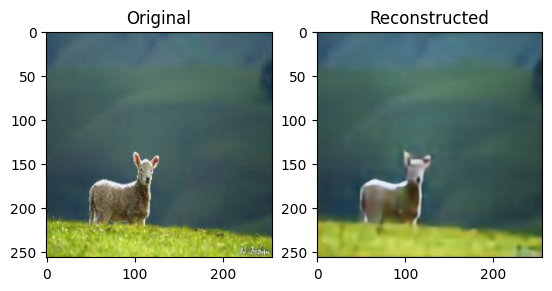

In [6]:
import random
num=random.randint(0, len(img_array2)-1)
test_img = np.expand_dims(img_array[num], axis=0)
pred = autoencoder_model.predict(test_img)

plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('Reconstructed')
plt.show()

**creating an encoder**

In [7]:
from keras.models import Model
from keras.layers import Input

# Define the input shape
input_shape = (256, 256, 3)

# Create the input layer
input_img = Input(shape=input_shape)

# # Build the encoder using the existing function
# encoder = build_encoder(input_img)

# # Assuming `autoencoder` is your pretrained model
# # Extract the intermediate layers corresponding to the feature maps you want
# encoder_outputs = [
#     autoencoder_model.get_layer(name).output for name in [
#         #'activation_1', 
#         #'activation_3', 
#         #'activation_5', 
#         #'activation_7', 
#         'activation_9'
#     ]
# ]

# # Create a new model for the encoder outputs
# encoder_model = Model(inputs=autoencoder_model.input, outputs=encoder_outputs)

# # Print the summary of the new model
# print(encoder_model.summary())

encoder = build_encoder(input_img)
encoder_model = Model(input_img, encoder)
print(encoder_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             

 Total params: 18,859,072 (71.94 MB)

 Trainable params: 18,851,136 (71.91 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


In [8]:
num_encoder_layers = len(encoder_model.layers) #35 layers in our encoder.
num_encoder_layers

35

**Copy already trained weights to new encoder**

In [9]:
for l1, l2 in zip(encoder_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())

In [10]:
autoencoder_weights = autoencoder_model.get_weights()[0][1]
encoder_weights = encoder_model.get_weights()[0][1]

**Taking a sample of content ans style images**

In [11]:
import cv2
from keras.preprocessing.image import img_to_array

SIZE=256

c_data=[]

img=cv2.imread('/kaggle/input/dataset/resized_images/000000002797.jpg', 1)   #Change 1 to 0 for grey images
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
c_data.append(img_to_array(img))

img_array = np.reshape(c_data, (len(c_data), SIZE, SIZE, 3))
c_array = img_array.astype('float32') / 255.

In [12]:
s_data=[]

#img=cv2.imread('data/mito/images/img9.tif', 1)

img=cv2.imread('/kaggle/input/images/WhatsApp Image 2022-10-24 at 20.50.52.jpeg', 1)   #Change 1 to 0 for grey images
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
s_data.append(img_to_array(img))

img_array = np.reshape(s_data, (len(s_data), SIZE, SIZE, 3))
s_array = img_array.astype('float32') / 255.

**feature maps of content and style from encoder**

In [13]:
c_encoded = encoder_model.predict(c_array)
s_encoded = encoder_model.predict(s_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [14]:
import tensorflow as tf
import numpy as np

# Using different WCT operations 
**Required functions for combined feature formation**

In [15]:
import tensorflow as tf

def inv_sqrt_cov(cov, inverse=False):
    s, u, _ = tf.linalg.svd(cov + tf.eye(cov.shape[-1])) 
    n_s = tf.reduce_sum(tf.cast(tf.greater(s, 1e-5), tf.int32))
    s = tf.sqrt(s[:,:n_s])
    if inverse:
        s = 1 / s
    d = tf.linalg.diag(s)
    u = u[:,:,:n_s]
    return tf.matmul(u, tf.matmul(d, u, adjoint_b=True))

def stylize_core(c_feat, s_feat, opt='zca'):
    n_batch, cont_h, cont_w, n_channel = c_feat.shape
    #_c_feat = tf.reshape(tf.transpose(c_feat, [0, 3, 1, 2]), [n_batch, n_channel, -1])
    if opt == 'zca':
        return stylize_zca(c_feat, s_feat) 
    elif opt == 'ot':
        return stylize_ot(c_feat, s_feat) 
    elif opt == 'adain':
        return stylize_adain(c_feat, s_feat)  

    #c_feat = tf.transpose(tf.reshape(c_feat, [n_batch, n_channel, cont_h, cont_w]), [0, 2, 3, 1])
    return c_feat

def stylize_adain(c_feat, s_feat):
    m_c = tf.reduce_mean(c_feat, axis=-1, keepdims=True)
    m_s = tf.reduce_mean(s_feat, axis=-1, keepdims=True) 
    c_feat = c_feat - m_c
    s_feat = s_feat - m_s 
    s_c = tf.sqrt(tf.reduce_mean(c_feat * c_feat, axis=-1, keepdims=True) + 1e-8)
    s_s = tf.sqrt(tf.reduce_mean(s_feat * s_feat, axis=-1, keepdims=True) + 1e-8) 
    white_c_feat = c_feat / s_c
    feat = white_c_feat * s_s + m_s     
    return feat

def stylize_zca(c_feat, s_feat): 
    m_c = tf.reduce_mean(c_feat, axis=-1, keepdims=True)
    m_s = tf.reduce_mean(s_feat, axis=-1, keepdims=True) 
    c_feat = c_feat - m_c
    s_feat = s_feat - m_s
    c_cov = tf.matmul(c_feat, c_feat, transpose_b=True) / c_feat.shape[-1]
    s_cov = tf.matmul(s_feat, s_feat, transpose_b=True) / s_feat.shape[-1] 
    inv_sqrt_c_cov = inv_sqrt_cov(c_cov, True)
    opt = tf.matmul(inv_sqrt_cov(s_cov), inv_sqrt_c_cov) 
    feat = tf.matmul(opt, c_feat) + m_s 
    return feat

def stylize_ot(c_feat, s_feat):
    m_c = tf.reduce_mean(c_feat, axis=-1, keepdims=True)
    m_s = tf.reduce_mean(s_feat, axis=-1, keepdims=True) 
    c_feat = c_feat - m_c
    s_feat = s_feat - m_s 
    c_cov = tf.matmul(c_feat, c_feat, transpose_b=True) / c_feat.shape[-1]
    s_cov = tf.matmul(s_feat, s_feat, transpose_b=True) / s_feat.shape[-1] 
    sqrt_c_cov = inv_sqrt_cov(c_cov)
    inv_sqrt_c_cov = inv_sqrt_cov(c_cov, True)
    opt = inv_sqrt_cov(tf.matmul(sqrt_c_cov, tf.matmul(s_cov, sqrt_c_cov))) 
    opt = tf.matmul(inv_sqrt_c_cov, tf.matmul(opt, inv_sqrt_c_cov))
    feat = tf.matmul(opt, c_feat) + m_s 
    return feat

**Now build decoder**

In [16]:
input_shape = (16,16,1024)
input_ten = Input(shape = input_shape)

decoder = build_decoder(input_ten)
decoder_model = Model(input_ten, decoder)
print(decoder_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 16, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 128)  │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 128)  │           51

 Total params: 9,064,451 (34.58 MB)

 Trainable params: 9,060,611 (34.56 MB)

 Non-trainable params: 3,840 (15.00 KB)

None


In [17]:
num_decoder_layers = len(decoder_model.layers)  # 30 layers in our decoder.
num_autoencoder_layers = len(autoencoder_model.layers)  # 64 layers in our autoencoder.

In [18]:
print(num_decoder_layers)
print(num_autoencoder_layers)

30
64


In [19]:
decoder_model.layers[0] = encoder_model.layers[34]

In [20]:
for l1, l2 in zip(decoder_model.layers[1:30], autoencoder_model.layers[35:64]):
    l1.set_weights(l2.get_weights())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


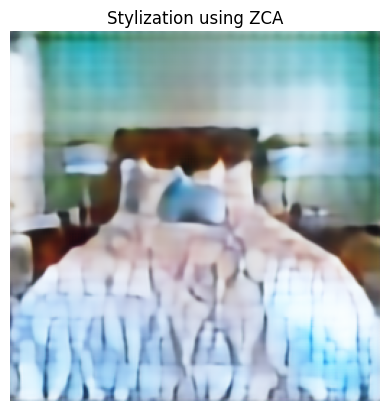

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


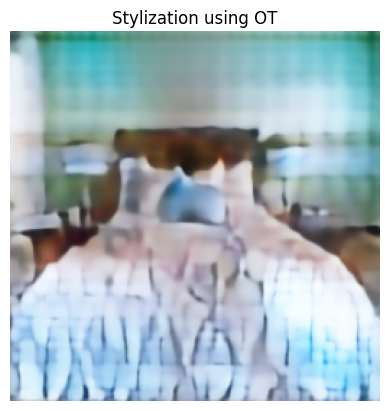

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


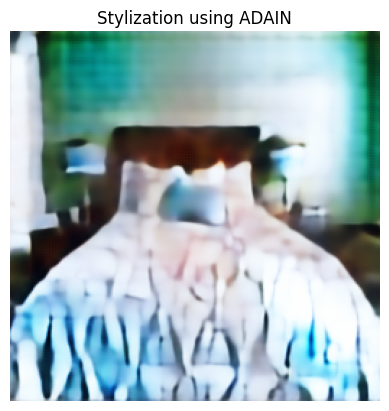

In [21]:
options = ['zca', 'ot', 'adain']

for opt in options:
    # Apply stylization using the current option
    cs_encoded = stylize_core(c_encoded, s_encoded, opt=opt)
    cs_decoded = decoder_model.predict(cs_encoded)
    
    # Reshape and plot the image
    image = cs_decoded.reshape(256, 256, 3)
    plt.figure()  # Create a new figure for each image
    plt.imshow(image)
    plt.title(f'Stylization using {opt.upper()}')
    plt.axis('off')  # Hide axes
    plt.show()

# Using Distance Method

In [22]:
import tensorflow as tf

def wasserstein_distance(x, y):
    # Compute the Wasserstein distance between x and y
    x_cdf = tf.cumsum(tf.sort(x, axis=-1), axis=-1)
    y_cdf = tf.cumsum(tf.sort(y, axis=-1), axis=-1)
    return tf.reduce_mean(tf.abs(x_cdf - y_cdf))

def stylize_wasserstein(c_feat, s_feat):
    m_c = tf.reduce_mean(c_feat, axis=-1, keepdims=True)
    m_s = tf.reduce_mean(s_feat, axis=-1, keepdims=True)
    c_feat = c_feat - m_c
    s_feat = s_feat - m_s
    loss = wasserstein_distance(c_feat, s_feat)
    # Apply transformation based on the loss
    feat = c_feat + m_s
    return feat

In [23]:
cs_encoded_using_dist = stylize_wasserstein(c_encoded, s_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


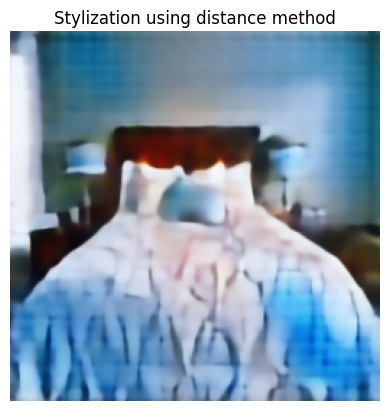

In [24]:
 cs_decoded = decoder_model.predict(cs_encoded_using_dist)
    
# Reshape and plot the image
image = cs_decoded.reshape(256, 256, 3)
plt.figure()  # Create a new figure for each image
plt.imshow(image)
plt.title(f'Stylization using distance method')
plt.axis('off')  # Hide axes
plt.show()

# Using NST method

In [25]:
import tensorflow as tf

# Helper function to compute the Gram matrix
def gram_matrix(features):
    # Reshape features to shape [batch_size, num_channels, height * width]
    batch_size, height, width, num_channels = tf.shape(features)
    features = tf.reshape(features, [batch_size, num_channels, height * width])
    gram = tf.matmul(features, features, transpose_b=True)
    gram /= tf.cast(height * width * num_channels, tf.float32)
    return gram

# Compute the content loss
def content_loss(content_features, generated_features):
    return tf.reduce_mean(tf.square(content_features - generated_features))

# Compute the style loss
def style_loss(style_features, generated_features):
    style_gram = gram_matrix(style_features)
    generated_gram = gram_matrix(generated_features)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

# Total Variation Loss to reduce noise
def total_variation_loss(image):
    x_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    y_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    return tf.reduce_sum(tf.square(x_var)) + tf.reduce_sum(tf.square(y_var))

# Define the NST function
def neural_style_transfer(c_encoded, s_encoded, iterations=1500, content_weight=1e4, style_weight=1e2, tv_weight=1e-6):
    # Create a placeholder for the generated image
    generated_image = tf.Variable(tf.random.normal(c_encoded.shape), trainable=True)

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

    # Create a list to store content and style losses
    content_losses = []
    style_losses = []

    # Define the optimization process
    for iteration in range(iterations):
        with tf.GradientTape() as tape:
            # Forward pass to get feature maps
            c_features = c_encoded
            s_features = s_encoded
            g_features = generated_image

            # Compute losses
            c_loss = content_loss(c_features, g_features)
            s_loss = style_loss(s_features, g_features)
            tv_loss = total_variation_loss(generated_image)
            total_loss = content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss

            # Compute gradients
            gradients = tape.gradient(total_loss, generated_image)
            optimizer.apply_gradients([(gradients, generated_image)])

            # Print progress
            if iteration % 100 == 0:
                print(f"Iteration {iteration}: Total Loss = {total_loss.numpy()}")

    return generated_image

# Example usage
# Assuming c_encoded and s_encoded are your feature maps of shape (16, 16, 1024)
# c_encoded = tf.random.normal([1, 16, 16, 1024])
# s_encoded = tf.random.normal([1, 16, 16, 1024])

result_image = neural_style_transfer(c_encoded, s_encoded)

Iteration 0: Total Loss = 14628.5888671875
Iteration 100: Total Loss = 1240.49169921875
Iteration 200: Total Loss = 169.020263671875
Iteration 300: Total Loss = 31.253183364868164
Iteration 400: Total Loss = 6.936272144317627
Iteration 500: Total Loss = 1.7538721561431885
Iteration 600: Total Loss = 0.5393116474151611
Iteration 700: Total Loss = 0.24791376292705536
Iteration 800: Total Loss = 0.18012776970863342
Iteration 900: Total Loss = 0.16538351774215698
Iteration 1000: Total Loss = 0.16244900226593018
Iteration 1100: Total Loss = 0.161921426653862
Iteration 1200: Total Loss = 0.16183646023273468
Iteration 1300: Total Loss = 0.16188034415245056
Iteration 1400: Total Loss = 0.16184411942958832


In [26]:
result_image.shape

TensorShape([1, 16, 16, 1024])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


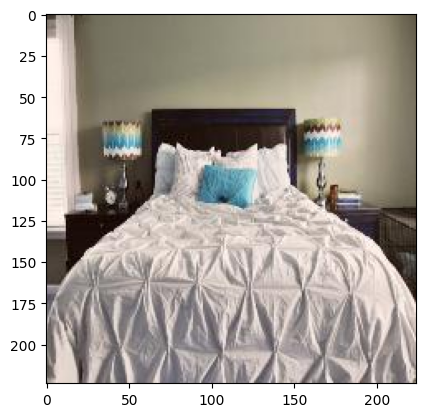

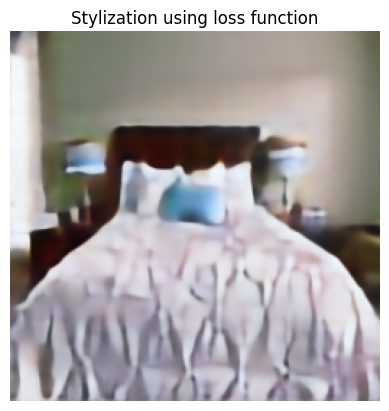

In [27]:
 cs_decoded = decoder_model.predict(result_image)
    
# Reshape and plot the image
img=cv2.imread('/kaggle/input/dataset/resized_images/000000002797.jpg', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = cs_decoded.reshape(256, 256, 3)
plt.figure(121)  # Create a new figure for each image
plt.imshow(img)
plt.figure(122)
plt.imshow(image)
plt.title(f'Stylization using loss function')
plt.axis('off')  # Hide axes
plt.show()

In [28]:
print(Done)

NameError: name 'Done' is not defined

# Combination of multiple features for WCT operation

In [ ]:
from keras.models import Model
from keras.layers import Input

# Define the input shape
input_shape = (256, 256, 3)

# Create the input layer
input_img = Input(shape=input_shape)

# Build the encoder using the existing function
encoder = build_encoder(input_img)

# Assuming `autoencoder` is your pretrained model
# Extract the intermediate layers corresponding to the feature maps you want
encoder_outputs = [
    autoencoder_model.get_layer(name).output for name in [
        #'activation_1', 
        #'activation_3', 
        #'activation_5', 
        'activation_7', 
        'activation_9'
    ]
]

# Create a new model for the encoder outputs
encoder_model = Model(inputs=autoencoder_model.input, outputs=encoder_outputs)

# Print the summary of the new model
print(encoder_model.summary())

In [ ]:
cs_encoded = stylize_core(c_encoded, s_encoded, opt='zca')

cs_decoded = decoder_model.predict(cs_encoded)

In [ ]:
cs_decoded.shape

In [ ]:
import matplotlib.pyplot as plt

# Assuming cs_decoded is a NumPy array
# Reshape from (1, 256, 256, 3) to (256, 256, 3)
image = cs_decoded.reshape(256, 256, 3)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Optional: to hide the axes
plt.show()

In [ ]:
#Saving encoder weights for future comparison
np.save('/kaggle/working/pretrained_encoder-weights.npy', encoder_weights )

In [ ]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape)

In [ ]:
unet_layer_names=[]
for layer in unet_model.layers:
    unet_layer_names.append(layer.name)

autoencoder_layer_names = []
for layer in autoencoder_model.layers:
    autoencoder_layer_names.append(layer.name)

In [ ]:
for l1, l2 in zip(unet_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())

In [ ]:
pip install tensorflow==2.9.0 keras==2.9.0 segmentation-models==1.0.1 efficientnet==1.1.1

In [ ]:
#from keras.optimizers import Adam
#import segmentation_models as sm
#unet_model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

print(unet_model.output_shape)

unet_model.save('/kaggle/working/unet_model_weights.h5')

In [ ]:
from tqdm import tqdm

SIZE = 256

image_directory = '/kaggle/input/face-segg/img'
image_dataset = []

mask_directory = '/kaggle/input/face-segg/masks'
mask_dataset = []

images = os.listdir(image_directory)
images = sorted(images)
# sort
for i in tqdm(images):
    img = cv2.imread(os.path.join(image_directory, i), 1)  # Read color images
    img = cv2.resize(img, (SIZE, SIZE))
    image_dataset.append(img_to_array(img))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
masks = sorted(masks)
for i in tqdm(masks):
    img = cv2.imread(os.path.join(mask_directory, i), 1)  # Read color images
    img = cv2.resize(img, (SIZE, SIZE))
    mask_dataset.append(img_to_array(img))


#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.array(mask_dataset)/255.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20)

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256, 3)))
plt.show()

print(image_number)

In [ ]:
pre_trained_unet_model = build_unet(input_shape)
pre_trained_unet_model.load_weights('unet_model_weights.h5')
pre_trained_unet_model_weights = pre_trained_unet_model.get_weights()[0][1]

#Load previously saved pretrained encoder weights just for comparison with the unet weights (Sanity check)
pretrained_encoder_wts = np.load('pretrained_encoder-weights.npy')

if pre_trained_unet_model_weights.all() == pretrained_encoder_wts.all():
    print("Both weights are identical")
else: 
    print("Something wrong, weghts are different")

In [ ]:
pre_trained_unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size=4

In [ ]:
pre_trained_unet_model_history = pre_trained_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    save_best_only = True,
                    epochs=250)

In [ ]:
pre_trained_unet_model.save('/kaggle/working/pre_trained_unet_model_250epochs.h5')

In [ ]:
model = load_model('/kaggle/working/pre_trained_unet_model_25epochs.h5', compile = False)

In [ ]:
import random
num=random.randint(0, len(image_dataset)-1)
test_img = np.expand_dims(image_dataset[num], axis=0)
pred = model.predict(test_img)

plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('segmented')
plt.show()

In [ ]:
img=cv2.imread('/kaggle/input/images/WhatsApp Image 2024-01-09 at 20.03.02_c23d041d.jpg', 1)   #Change 1 to 0 for grey images
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.

In [ ]:
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, Conv2DTranspose
from tensorflow.keras.models import Sequential
import os
from keras.models import Model
from matplotlib import pyplot as plt

SIZE=256


from tqdm import tqdm

img_data=[]
path1 = '/kaggle/input/dataset/resized_images'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))
    

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.

#In the interest of time let us train on 500 images
img_array2 = img_array[200:700]

In [ ]:
autoencoder_model=build_autoencoder(img.shape)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(autoencoder_model.summary())

In [ ]:
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
history = autoencoder_model.fit(img_array2, img_array2,
        epochs=30, verbose=1)

In [ ]:
autoencoder_model.save('autoencoder_mito_500imgs_100epochs.h5')

In [ ]:
from keras.models import load_model
autoencoder_model = load_model("autoencoder_mito_500imgs_100epochs.h5", compile=False)
       
import random
num=random.randint(0, len(img_array2)-1)
test_img = np.expand_dims(img_array[num], axis=0)
pred = autoencoder_model.predict(test_img)

plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('Reconstructed')
plt.show()

In [ ]:
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")

# Ensure they are float32
print(f"Train images dtype: {train_images.dtype}")
print(f"Validation images dtype: {val_images.dtype}")

In [ ]:
import tensorflow as tf

def create_dataset(images, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(train_images, BATCH_SIZE)
val_dataset = create_dataset(val_images, BATCH_SIZE)

# Check the dataset output
for batch in train_dataset.take(1):
    print(batch.shape)

In [ ]:
train_dataset

In [ ]:
def build_auto__len__encoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return autoencoder

input_shape = (SIZE, SIZE, 3)
model = build_autoencoder(input_shape)
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_path = '/kaggle/working/best_model.keras'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint]
)

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
for batch in train_dataset.take(1):
    print(f"Batch shape: {batch.shape}")

In [ ]:
pip install --upgrade tensorflow

In [ ]:
# Build the model
input_shape = (SIZE, SIZE, 3)
model = build_autoencoder(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint]
)

In [ ]:
# Build and compile the model
input_shape = (SIZE, SIZE, 3)
model = build_autoencoder(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, period=5):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.period = period
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))
            print(f'\nEpoch {epoch + 1}: Model saved to {self.filepath.format(epoch=epoch + 1)}')


# Instantiate the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',  # Save model files with epoch number
    period=5  # Save every 5 epochs
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Total number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[custom_checkpoint]  # Add the custom callback here
)


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model


#np.random.seed(42)

SIZE=256
img_data=[]

#img=cv2.imread('data/mito/images/img9.tif', 1)

img=cv2.imread('/kaggle/input/images/WhatsApp Image 2022-10-24 at 20.50.52.jpeg', 1)   #Change 1 to 0 for grey images
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.

model=build_autoencoder(img.shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(model.summary())

In [ ]:
model.fit(img_array, img_array,
        epochs=800,
        shuffle=True)

In [ ]:

pred = model.predict(img_array)

#pred_u8 = (pred[0].reshape(128,128,3)).astype(np.uint8)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('Reconstructed')
plt.show()

In [ ]:
pip install torch torchvision transformers


In [ ]:
import torch
from transformers import VQVAEModel, VQVAEConfig
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the device to use (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained VQ-VAE model from Hugging Face
model_name = "facebook/vqvae"

# Load the VQ-VAE model
model = VQVAEModel.from_pretrained(model_name).to(device)

# Set the model to evaluation mode
model.eval()

# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load a sample dataset (e.g., MNIST)
dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Get a sample image from the dataset
data_iter = iter(dataloader)
images, labels = data_iter.next()
images = images.to(device)

# Perform image reconstruction using the VQ-VAE model
with torch.no_grad():
    reconstructed_images = model(images).logits

# Convert the reconstructed images to a format suitable for visualization
reconstructed_images = reconstructed_images.squeeze(0).cpu().numpy().transpose(1, 2, 0)
reconstructed_images = (reconstructed_images + 1) / 2  # Denormalize

# Visualize the original and reconstructed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(images.squeeze(0).cpu().numpy().transpose(1, 2, 0), cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(reconstructed_images, cmap='gray')
axes[1].set_title('Reconstructed Image')
plt.show()

In [ ]:
pip install transformers torch pillow

In [ ]:
from transformers import Swin2SRModel, Swin2SRFeatureExtractor
from PIL import Image
import torch
import requests
from io import BytesIO

# Load pre-trained model and feature extractor
model = Swin2SRModel.from_pretrained("huggingface/swin2sr")
feature_extractor = Swin2SRFeatureExtractor.from_pretrained("huggingface/swin2sr")

# Load and prepare the image
url = "https://logos-world.net/wp-content/uploads/2020/09/Google-Logo.png"  # Replace with your image URL or local path
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform image reconstruction
with torch.no_grad():
    outputs = model(**inputs)

# Post-process and save the reconstructed image
reconstructed_image = outputs.logits.squeeze().permute(1, 2, 0).numpy()
reconstructed_image = (reconstructed_image * 255).astype("uint8")
reconstructed_image_pil = Image.fromarray(reconstructed_image)
reconstructed_image_pil.save("/kaggle/working/reconstructed_image.jpg")

print("Image reconstruction completed and saved as 'reconstructed_image.jpg'")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the dataset
data_path = '/kaggle/input/dataset/resized_images'
image_size = (128, 128)  # Resize images to a fixed size for the GAN

# Function to load images
def load_images(path, size):
    images = []
    for filename in os.listdir(path):
        img = load_img(os.path.join(path, filename), target_size=size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

# Load and normalize images
images = load_images(data_path, image_size)
images = (images.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]

# Plot some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow((images[i] + 1) / 2)
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation, Concatenate, Input
from tensorflow.keras.models import Model

# Generator model
def build_generator():
    inputs = Input(shape=(128, 128, 3))

    # Encoder
    down1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    down1 = LeakyReLU(alpha=0.2)(down1)

    down2 = Conv2D(128, kernel_size=4, strides=2, padding='same')(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(alpha=0.2)(down2)

    down3 = Conv2D(256, kernel_size=4, strides=2, padding='same')(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU(alpha=0.2)(down3)

    down4 = Conv2D(512, kernel_size=4, strides=2, padding='same')(down3)
    down4 = BatchNormalization()(down4)
    down4 = LeakyReLU(alpha=0.2)(down4)

    # Decoder
    up1 = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(down4)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Concatenate()([up1, down3])

    up2 = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(up1)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Concatenate()([up2, down2])

    up3 = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(up2)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Concatenate()([up3, down1])

    up4 = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')(up3)
    outputs = Activation('tanh')(up4)

    return Model(inputs, outputs)

def build_discriminator():
    inputs = Input(shape=(128, 128, 3))
    targets = Input(shape=(128, 128, 3))

    merged = Concatenate()([inputs, targets])

    down1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(merged)
    down1 = LeakyReLU(alpha=0.2)(down1)

    down2 = Conv2D(128, kernel_size=4, strides=2, padding='same')(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(alpha=0.2)(down2)

    down3 = Conv2D(256, kernel_size=4, strides=2, padding='same')(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU(alpha=0.2)(down3)

    down4 = Conv2D(512, kernel_size=4, strides=2, padding='same')(down3)
    down4 = BatchNormalization()(down4)
    down4 = LeakyReLU(alpha=0.2)(down4)

    # Ensure the final output shape matches the valid/fake tensor shapes
    down5 = Conv2D(1, kernel_size=4, strides=1, padding='same')(down4)
    outputs = Activation('sigmoid')(down5)

    return Model([inputs, targets], outputs)

# Instantiate the models
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Define the combined model (generator + discriminator)
discriminator.trainable = False
inputs = Input(shape=(128, 128, 3))
generated_image = generator(inputs)
validity = discriminator([inputs, generated_image])

combined = Model(inputs, validity)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

In [ ]:
import shutil
import os

def clear_directory(directory_path):
    """Remove all files and subdirectories in the given directory."""
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Cleared directory: {directory_path}")
    else:
        print(f"Directory does not exist: {directory_path}")

# Example usage:
directory_to_clear = '/kaggle/working/'
clear_directory(directory_to_clear)

In [ ]:
# Training parameters
epochs = 100  # Change to 10 epochs
batch_size = 32
sample_interval = 100  # Save samples more frequently due to fewer epochs

# Ensure the valid and fake tensors match the discriminator output shape
valid = np.ones((batch_size, 8, 8, 1))
fake = np.zeros((batch_size, 8, 8, 1))

# Training loop
for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, images.shape[0], batch_size)
    imgs = images[idx]

    # Generate a batch of new images
    gen_imgs = generator.predict(imgs)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, imgs], valid)
    d_loss_fake = discriminator.train_on_batch([imgs, gen_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = combined.train_on_batch(imgs, valid)

    # Print the progress
    if(epoch%100 == 0):
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        # Save generated image samples
        r, c = 5, 5
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"images_at_epoch_{epoch}.png")
        plt.close()

# Save the trained models
generator.save('/kaggle/working/generator.h5')
discriminator.save('/kaggle/working/discriminator.h5')
combined.save('/kaggle/working/combined.h5')

print("Models saved to kaggle/working/")

In [ ]:
# Load a resized image and use the generator to reconstruct the original
def reconstruct_image(image_path, generator):
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = (img_array.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)

    reconstructed_img = generator.predict(img_array)
    reconstructed_img = 0.5 * reconstructed_img + 0.5  # Rescale to [0, 1]

    return reconstructed_img[0]

# Reconstruct an image
image_path = '/kaggle/input/dataset/resized_images/000000000001.jpg'
reconstructed_img = reconstruct_image(image_path, generator)

# Display the original resized and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Resized Image")
plt.imshow(load_img(image_path, target_size=image_size))

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_img)
plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Data Augmentation and Data Generators
def data_generator(folder, batch_size=16, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    generator = datagen.flow_from_directory(
        folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,  # Adjust as needed for your task
        shuffle=True
    )
    return generator

# Define the U-Net model with VGG19 encoder
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Dropout(0.5)(x)
    
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    inputs = Input(input_shape)
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    
    # Freeze VGG19 layers
    for layer in vgg19.layers:
        layer.trainable = False

    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    b1 = vgg19.get_layer("block5_conv4").output

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(3, 3, padding='same')(d4)
    outputs = BatchNormalization()(outputs)
    outputs = Activation("relu")(outputs)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model 

# Define additional metrics
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_index(y_true, y_pred):
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return ssim_value

# Load VGG19 model for perceptual loss calculation
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
vgg19.trainable = False
feature_extractor = tf.keras.Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)

def perceptual_loss(y_true, y_pred):
    y_true_features = feature_extractor(y_true)
    y_pred_features = feature_extractor(y_pred)
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

# Set up learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(lr_schedule)

# Load images from folder (if necessary)
def load_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.astype('float32') / 255.
        images.append(img_array)
    return np.array(images)

# Define training folder and data
train_folder = '/kaggle/input/dataset/resized_images'
train_images = load_images_from_folder(train_folder)

# Create U-Net model
input_shape = (224, 224, 3)
model = build_vgg19_unet(input_shape)
model.compile(optimizer='adam', loss=perceptual_loss, metrics=[psnr, ssim_index])
model.summary()

# Define checkpoint callback
checkpoint = ModelCheckpoint(
    '/kaggle/working/model_epoch_{epoch:02d}.keras',  
    monitor='val_loss',
    save_best_only=True,   
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# Train the model
history = model.fit(
    train_images, train_images,
    epochs=4,  # Increase epochs if necessary
    batch_size=16,
    shuffle=True,
    validation_split=0.2,  
    callbacks=[checkpoint, lr_scheduler]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess a test image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array.astype('float32') / 255.
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Predict with the model
def predict_image(model, image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    return prediction

# Display images
def display_images(original_image_path, prediction):
    original_image = load_img(original_image_path)
    original_image = img_to_array(original_image)
    
    # Rescale prediction to original image size
    prediction_rescaled = prediction.squeeze()  # Remove batch dimension
    prediction_rescaled = (prediction_rescaled * 255).astype(np.uint8)  # Rescale to [0, 255]
    
    # Display images
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image / 255.)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Image')
    plt.imshow(prediction_rescaled)
    plt.axis('off')
    
    plt.show()

# Test the model with a new image
image_path = '/kaggle/input/dataset/resized_images/000000000001.jpg'  # Replace with your image path
prediction = predict_image(model, image_path)

# Display the results
display_images(image_path, prediction)